In [1]:
from util import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=[FutureWarning])

# Retrieve cleaned data and Scale values

In [2]:
rawtest = pd.read_csv('./data/test.csv')
datatrain = pd.read_csv('cl_train.csv')
datatest = pd.read_csv('cl_test.csv')

In [116]:
X = datatrain.drop(columns=['Survived', 'PassengerId'])
Y = datatrain['Survived']
Xt = datatest.drop(columns=['PassengerId'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Xt_scaled = scaler.fit_transform(Xt)

In [4]:
X.shape, Xt.shape, Y.shape

((891, 12), (418, 12), (891,))

In [5]:
X.head(3)

,Age,Embarked,Fare,Parch,Pclass,Sex_code,SibSp,FamilySize,Mr,Miss,Mrs,Master
0,22.0,2,7.2500,0,3,1,1,1,1,0,0,0
1,38.0,0,71.2833,0,1,0,1,1,0,0,1,0
2,26.0,2,7.9250,0,3,0,0,0,0,1,0,0


In [6]:
Xt.head(3)

,Age,Embarked,Fare,Parch,Pclass,Sex_code,SibSp,FamilySize,Mr,Miss,Mrs,Master
0,34.5,1,7.8292,0,3,1,0,0,1,0,0,0
1,47.0,2,7.0000,0,3,0,1,1,0,0,1,0
2,62.0,1,9.6875,0,2,1,0,0,1,0,0,0


# Test Accuracy of each feature with respect to our Predictor

Mr            0.789238
Sex_code      0.762332
Mrs           0.730942
Pclass        0.699552
Fare          0.695067
SibSp         0.690583
Miss          0.677130
Embarked      0.668161
Age           0.654709
FamilySize    0.627803
Master        0.623318
Parch         0.623318
dtype: float64

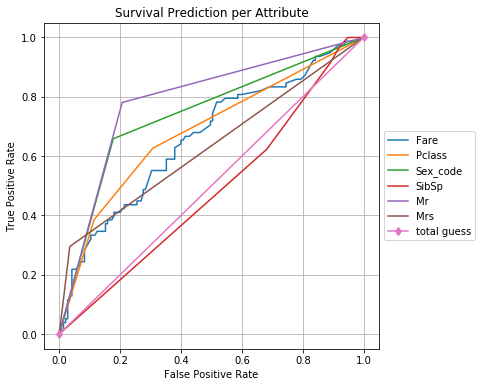

In [7]:
thres = 0.68
temp_acc = pd.Series()

for c in X.columns.tolist():
    tempX = np.array(X[c]).reshape(-1, 1)
    XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(tempX, Y)
    my_model = LogisticRegression(solver='liblinear').fit(XTRAIN, YTRAIN)
    model_prediction = my_model.predict(XTEST)
    acc = accuracy_score(YTEST, model_prediction)
    temp_acc[c] = acc
    if acc > thres:
        SY = my_model.predict_proba(XTEST)[:,1] # second column = probability
        SFPR, STPR, STHRESH = roc_curve(YTEST, SY)
        plt.plot(SFPR, STPR, label=c)
    
plt.plot([0,1],[0,1], label='total guess', marker='d')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Survival Prediction per Attribute")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.gcf().set_size_inches(6,6)

temp_acc.sort_values(ascending=False)

In [8]:
print("Worst predictors")
temp_acc.sort_values(ascending=False)[8:]

Worst predictors


Age           0.654709
FamilySize    0.627803
Master        0.623318
Parch         0.623318
dtype: float64

# GridSearch over the best parameters

In [124]:
def show_grid_results(grid_search, all=True):
    print('Best parameters:\n', grid_search.best_params_, '\n', grid_search.best_score_, '\n')
    if all:
        cvres = grid_search.cv_results_
        for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
            print(mean_score, params)
        
def horizontal_barplot(grid_search):
    fig, ax = plt.subplots(figsize=(20,10))
    xplot = grid_search.cv_results_['mean_test_score']
    yplot = [str(i) for i in grid_search.cv_results_['params']]
    ax = sns.barplot(x=xplot, y=yplot, palette=sns.light_palette("yellow", n_colors=len(xplot), reverse=True))
    # plt.ylabel("")
    plt.xlabel('Times appearing', fontsize=20)
    plt.title('Parameters Accuracy', fontsize=25)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 3, p.get_y() + p.get_height()/1.4, "%d" % width, ha="center", fontsize=15)
    sns.despine()
    # plt.savefig('img/top_words_in_songs.jpg')
    plt.plot();

In [148]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    { 'solver':['liblinear'] },
    { 'solver':['newton-cg'], 'penalty':['l2', 'none'], 'multi_class':['ovr', 'multinomial', 'auto'] },
    { 'solver':['lbfgs'], 'penalty':['l2', 'none'], 'multi_class':['ovr', 'multinomial', 'auto'] },
    { 'solver':['saga'], 'l1_ratio':[0.5, 0.6, 0.75, 0.9], 'max_iter':[800], 'penalty':['elasticnet'] },
    { 'solver':['sag'], 'penalty':['l2'] }
]
model = LogisticRegression()
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', return_train_score=True)
grid_search.fit(X_scaled, Y)
show_grid_results(grid_search)

best_est = grid_search.best_estimator_
best_score = grid_search.best_score_

Best parameters:
 {'l1_ratio': 0.75, 'max_iter': 800, 'penalty': 'elasticnet', 'solver': 'saga'} 
 0.8282828282828283 

0.8260381593714927 {'solver': 'liblinear'}
0.8260381593714927 {'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
0.8249158249158249 {'multi_class': 'ovr', 'penalty': 'none', 'solver': 'newton-cg'}
0.8260381593714927 {'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}
0.8249158249158249 {'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg'}
0.8260381593714927 {'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg'}
0.8249158249158249 {'multi_class': 'auto', 'penalty': 'none', 'solver': 'newton-cg'}
0.8260381593714927 {'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}
0.8249158249158249 {'multi_class': 'ovr', 'penalty': 'none', 'solver': 'lbfgs'}
0.8260381593714927 {'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
0.8249158249158249 {'multi_class': 'multinomial', 'penalty': 'none', 'solver'

## Evaluate optional datasets with less relevant features

In [197]:
optional_dfs = {
#     'drop_Fare': scaler.fit_transform(X.drop(columns=['Fare'])), # 0.8260381593714927
#     'drop_Fare_SibSp_Parch': scaler.fit_transform(X.drop(columns=['Fare', 'SibSp', 'Parch'])), # 0.8294051627384961
    'drop_SibSp_Parch': scaler.fit_transform(X.drop(columns=['SibSp', 'Parch'])), # 0.8305274971941639
#     'drop_SibSp_Parch_Master': scaler.fit_transform(X.drop(columns=['SibSp', 'Parch', 'Master'])), # 0.8181818181818182
#     'drop_Parch': scaler.fit_transform(X.drop(columns=['Parch'])), # 0.8282828282828283
#     'drop_Master': scaler.fit_transform(X.drop(columns=['Master'])), # 0.8148148148148148
#     'drop_Parch_Master': scaler.fit_transform(X.drop(columns=['Master', 'Parch'])), # 0.8148148148148148
#     'drop_FamilySize': scaler.fit_transform(X.drop(columns=['FamilySize'])), # 0.8282828282828283
#     'drop_FamilySize_Master': scaler.fit_transform(X.drop(columns=['FamilySize', 'Master'])), # 0.8148148148148148
#     'drop_FamilySize_Master_Parch': scaler.fit_transform(X.drop(columns=['FamilySize', 'Master', 'Parch'])), # 0.8159371492704826
#     'drop_Fare_SibSp_Parch': scaler.fit_transform(X.drop(columns=['Fare', 'SibSp', 'Parch'])), # 0.8294051627384961
#     'drop_Age': scaler.fit_transform(X.drop(columns=['Age'])), # 0.8226711560044894
    'drop_Sex': scaler.fit_transform(X.drop(columns=['Sex_code'])), # 0.8237934904601572
}

In [198]:
for name, df in optional_dfs.items():
    model = LogisticRegression()
    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', return_train_score=True)
    grid_search.fit(df, Y)
    print(name)
    show_grid_results(grid_search, all=False)
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_est = grid_search.best_estimator_

drop_SibSp_Parch
Best parameters:
 {'l1_ratio': 0.75, 'max_iter': 800, 'penalty': 'elasticnet', 'solver': 'saga'} 
 0.8305274971941639 

drop_Sex
Best parameters:
 {'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'} 
 0.8237934904601572 



# Found a better score after dropping **SibSp** and **Parch**
- Using parameters {'l1_ratio': 0.75, 'max_iter': 800, 'penalty': 'elasticnet', 'solver': 'saga'} 

In [173]:
Xbest = optional_dfs['drop_SibSp_Parch']
Xtbest = scaler.fit_transform(Xt.drop(columns=['SibSp', 'Parch']))

In [174]:
best_model = best_est
best_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.75, max_iter=800,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


<img src='https://cdn-images-1.medium.com/max/1200/1*uR09zTlPgIj5PvMYJZScVg.png' style='width:400px;'>

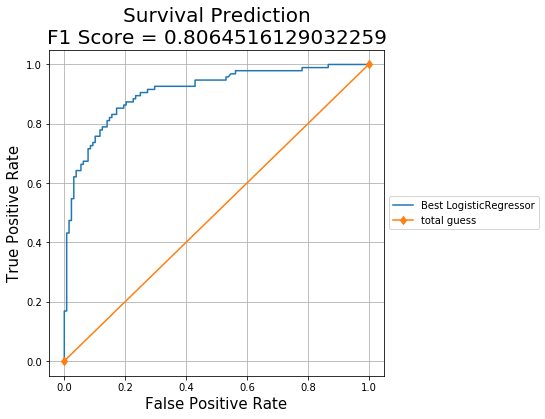

In [182]:
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(Xbest, Y)
SY = best_model.predict_proba(XTEST)[:,1] # second column = probability
SFPR, STPR, STHRESH = roc_curve(YTEST, SY)
YP = best_model.predict(XTEST)
cm = confusion_matrix(YTEST, YP)
f1score = f1_score(YTEST, YP)
plt.plot(SFPR, STPR, label='Best LogisticRegressor')
plt.plot([0,1],[0,1], label='total guess', marker='d')
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Survival Prediction\nF1 Score = "+str(f1score), fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.gcf().set_size_inches(6,6)

In [183]:
dfcm = pd.DataFrame(cm, columns=["Survived", "Not"]).set_index( pd.Index(['Survived', 'Not']) )
dfcm

,Survived,Not
Survived,112,16
Not,20,75


F1 SCORE:	 0.8064516129032259


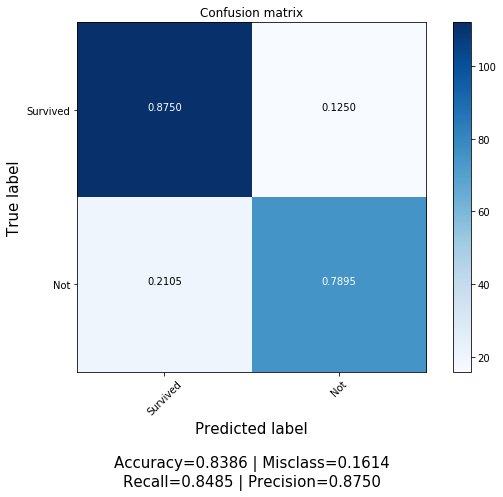

In [184]:
print('F1 SCORE:\t', f1score)
plot_confusion_matrix(cm, target_names=['Survived', 'Not'], normalize=True)

# Predict the test data

In [186]:
Yt = best_model.predict(Xtbest).astype(int)

In [187]:
output = pd.concat([datatest['PassengerId'], pd.Series(Yt)], axis=1)
output.columns=['PassengerId', 'Survived']
output.shape

(418, 2)

In [188]:
output.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,1


In [189]:
import datetime
date = datetime.datetime.now()
_result_file = './results/result_'+date.strftime("%b-%d %H %M %S")
output.to_csv(_result_file+str('.csv'), index=False)

# Kaggle Score 0.79425

- Columns used
    - Age	Embarked	Fare	Parch	Pclass	Sex_code	SibSp	FamilySize	Mr	Miss	Mrs	Master
- Fill NAs of **Age**, **Fare** and **Embarked** with mode
- Logistic Regression {'solver': 'liblinear'} 

# Kaggle Score 0.79904

- Columns used
    - Age	Embarked	Fare	Parch	Pclass	Sex_code	SibSp	FamilySize	Mr	Miss	Mrs	Master
- Fill NAs of **Age**, **Fare** and **Embarked** with mode
- Logistic Regression {'l1_ratio': 0.75, 'max_iter': 800, 'penalty': 'elasticnet', 'solver': 'saga'} 

# Kaggle Score 0.80382

- Columns used
    - Age	Embarked	Fare	Pclass	Sex_code	FamilySize	Mr	Miss	Mrs	Master
- Fill NAs of **Age**, **Fare** and **Embarked** with mode
- Logistic Regression {'l1_ratio': 0.75, 'max_iter': 800, 'penalty': 'elasticnet', 'solver': 'saga'} 

# Submitting the gender_submission.csv file gives a 0.76555 score

## Submitting the pclass_submission.csv file gives 0.58851 score
### Will only survive if pclass is 1 or 2

In [ ]:
# some_y = [ 0 if pclass > 2 else 1 for pclass in datatest['Pclass'] ]

In [ ]:
# some_output = pd.concat([datatest['PassengerId'], pd.Series(some_y)], axis=1)
# some_output.columns=['PassengerId', 'Survived']
# some_output.to_csv('./results/pclass_submission.csv', index=False)